# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# model

- LightGBM

[I 2024-01-22 10:53:27,087] A new study created in memory with name: no-name-2b2965db-99bf-4dbd-8a04-5a6277fbcdea


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.18625


[I 2024-01-22 10:53:27,313] Trial 0 finished with value: 0.81375 and parameters: {'lambda_l1': 0.022984155139589207, 'lambda_l2': 0.0501403183922622, 'num_leaves': 51, 'feature_fraction': 0.546703123617716, 'bagging_fraction': 0.9363820376617792, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:27,461] Trial 1 finished with value: 0.804375 and parameters: {'lambda_l1': 0.8562754352905516, 'lambda_l2': 1.0000255882470351e-07, 'num_leaves': 76, 'feature_fraction': 0.5023259340140629, 'bagging_fraction': 0.6190345630931483, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:27,581] Trial 2 finished with value: 0.795 and parameters: {'lambda_l1': 0.0028800021787964564, 'lambda_l2': 2.844910267631038e-05, 'num_leaves': 217, 'feature_fraction': 0.7902567475217641, 'bagging_fraction': 0.42468448322321617, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:27,726] Trial 3 finished with value: 0.80625 and parameters: {'lambda_l1': 2.1025897773022038e-07, 'lambda_l2': 1.894383205974205e-05, 'num_leaves': 26, 'feature_fraction': 0.7449414905787014, 'bagging_fraction': 0.7292562206174376, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.205
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:28,150] Trial 4 finished with value: 0.788125 and parameters: {'lambda_l1': 0.0009599944669768145, 'lambda_l2': 0.0007236009334043765, 'num_leaves': 204, 'feature_fraction': 0.8110097301313379, 'bagging_fraction': 0.8358082947860184, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:28,310] Trial 5 finished with value: 0.81 and parameters: {'lambda_l1': 0.4591397146817539, 'lambda_l2': 1.940315726242058e-05, 'num_leaves': 88, 'feature_fraction': 0.5679774508029866, 'bagging_fraction': 0.8886429542407612, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.211875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19


[I 2024-01-22 10:53:28,407] Trial 6 finished with value: 0.7975 and parameters: {'lambda_l1': 9.256701840894037e-05, 'lambda_l2': 0.00010327436407828617, 'num_leaves': 10, 'feature_fraction': 0.653402114243055, 'bagging_fraction': 0.5316805085651239, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:28,563] Trial 7 finished with value: 0.80625 and parameters: {'lambda_l1': 7.965014952801678e-06, 'lambda_l2': 2.1481393719214912e-07, 'num_leaves': 104, 'feature_fraction': 0.6861613859376918, 'bagging_fraction': 0.863322618147287, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.195625


[I 2024-01-22 10:53:28,777] Trial 8 finished with value: 0.804375 and parameters: {'lambda_l1': 5.315026021140319e-07, 'lambda_l2': 2.309081064587305, 'num_leaves': 110, 'feature_fraction': 0.5101719528478448, 'bagging_fraction': 0.7024729612338727, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:28,981] Trial 9 finished with value: 0.803125 and parameters: {'lambda_l1': 2.9870245549373053e-06, 'lambda_l2': 1.262150156759688e-06, 'num_leaves': 236, 'feature_fraction': 0.9919532253672926, 'bagging_fraction': 0.632778054572673, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:29,275] Trial 10 finished with value: 0.794375 and parameters: {'lambda_l1': 0.03626522351555334, 'lambda_l2': 0.04443251426606032, 'num_leaves': 165, 'feature_fraction': 0.45170078476381514, 'bagging_fraction': 0.9953507927803739, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.205625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_error: 0.199375


[I 2024-01-22 10:53:29,493] Trial 11 finished with value: 0.800625 and parameters: {'lambda_l1': 9.40686687055609, 'lambda_l2': 0.007678435664529523, 'num_leaves': 63, 'feature_fraction': 0.559136714420715, 'bagging_fraction': 0.9955225171157626, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:29,707] Trial 12 finished with value: 0.809375 and parameters: {'lambda_l1': 0.08004670273952981, 'lambda_l2': 1.6330921186528858e-08, 'num_leaves': 54, 'feature_fraction': 0.4201055282935313, 'bagging_fraction': 0.8713302312153774, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.194375


[I 2024-01-22 10:53:30,025] Trial 13 finished with value: 0.805625 and parameters: {'lambda_l1': 1.2860831541691201e-08, 'lambda_l2': 0.19766817497965547, 'num_leaves': 150, 'feature_fraction': 0.5904560740530803, 'bagging_fraction': 0.9416740056441643, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_error: 0.201875


[I 2024-01-22 10:53:30,278] Trial 14 finished with value: 0.798125 and parameters: {'lambda_l1': 0.024279150164697227, 'lambda_l2': 0.00202329297055748, 'num_leaves': 87, 'feature_fraction': 0.6019096692427136, 'bagging_fraction': 0.8044173527362549, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:30,621] Trial 15 finished with value: 0.805625 and parameters: {'lambda_l1': 0.544882959696881, 'lambda_l2': 5.519474965183787, 'num_leaves': 43, 'feature_fraction': 0.5083116525428333, 'bagging_fraction': 0.9271504693614144, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[108]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:30,904] Trial 16 finished with value: 0.8025 and parameters: {'lambda_l1': 0.006005525964340197, 'lambda_l2': 0.010980049933313937, 'num_leaves': 129, 'feature_fraction': 0.40205966997381704, 'bagging_fraction': 0.7779649561075634, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[56]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.196875


[I 2024-01-22 10:53:31,071] Trial 17 finished with value: 0.803125 and parameters: {'lambda_l1': 0.0003358997605983263, 'lambda_l2': 0.00035892467379571594, 'num_leaves': 31, 'feature_fraction': 0.6476901157632324, 'bagging_fraction': 0.9017085496267851, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:31,250] Trial 18 finished with value: 0.801875 and parameters: {'lambda_l1': 9.078701704408447, 'lambda_l2': 5.033341639205535e-06, 'num_leaves': 165, 'feature_fraction': 0.5354011377535273, 'bagging_fraction': 0.7876526514264275, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:31,388] Trial 19 finished with value: 0.803125 and parameters: {'lambda_l1': 0.3713786298408137, 'lambda_l2': 0.00010551558269260716, 'num_leaves': 7, 'feature_fraction': 0.4648808406960776, 'bagging_fraction': 0.9368778246616408, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[93]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:31,705] Trial 20 finished with value: 0.798125 and parameters: {'lambda_l1': 0.011676803293667642, 'lambda_l2': 0.1810231180826607, 'num_leaves': 91, 'feature_fraction': 0.5914135578294446, 'bagging_fraction': 0.8568286389861197, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:32,038] Trial 21 finished with value: 0.806875 and parameters: {'lambda_l1': 0.08739879419265789, 'lambda_l2': 1.1734594813498231e-08, 'num_leaves': 59, 'feature_fraction': 0.4130435752564951, 'bagging_fraction': 0.8779336721787229, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[65]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:32,237] Trial 22 finished with value: 0.808125 and parameters: {'lambda_l1': 0.10540890149080923, 'lambda_l2': 1.421040925959959e-06, 'num_leaves': 53, 'feature_fraction': 0.45694539263077033, 'bagging_fraction': 0.9035275845270708, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:32,530] Trial 23 finished with value: 0.800625 and parameters: {'lambda_l1': 0.003084283331540174, 'lambda_l2': 1.0942644326814426e-08, 'num_leaves': 118, 'feature_fraction': 0.46811850572403313, 'bagging_fraction': 0.8281064854051696, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:32,784] Trial 24 finished with value: 0.8075 and parameters: {'lambda_l1': 0.08171681461559013, 'lambda_l2': 0.003037921091186514, 'num_leaves': 74, 'feature_fraction': 0.5657180091601607, 'bagging_fraction': 0.9600778398964342, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:32,955] Trial 25 finished with value: 0.804375 and parameters: {'lambda_l1': 1.66227138014331, 'lambda_l2': 9.757673359234347e-08, 'num_leaves': 29, 'feature_fraction': 0.4013740049477046, 'bagging_fraction': 0.8900364052115616, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:33,294] Trial 26 finished with value: 0.80625 and parameters: {'lambda_l1': 0.19881260699057002, 'lambda_l2': 8.062024595157755e-06, 'num_leaves': 95, 'feature_fraction': 0.5354280849708705, 'bagging_fraction': 0.7591930960670119, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:33,474] Trial 27 finished with value: 0.798125 and parameters: {'lambda_l1': 0.020925103014459812, 'lambda_l2': 0.0007923759114514149, 'num_leaves': 74, 'feature_fraction': 0.4873504541083219, 'bagging_fraction': 0.8363998108948398, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.201875


[I 2024-01-22 10:53:33,688] Trial 28 finished with value: 0.805625 and parameters: {'lambda_l1': 2.2557902479512464, 'lambda_l2': 8.948569187553019e-05, 'num_leaves': 141, 'feature_fraction': 0.44099973592274977, 'bagging_fraction': 0.9809057340792227, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:33,913] Trial 29 finished with value: 0.809375 and parameters: {'lambda_l1': 0.7246756167200182, 'lambda_l2': 9.003105303542566e-08, 'num_leaves': 44, 'feature_fraction': 0.5051838621070616, 'bagging_fraction': 0.919763061876267, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:34,305] Trial 30 finished with value: 0.808125 and parameters: {'lambda_l1': 0.25242317520012875, 'lambda_l2': 7.369844816820204e-07, 'num_leaves': 68, 'feature_fraction': 0.48713760340103207, 'bagging_fraction': 0.9589669227409149, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:34,492] Trial 31 finished with value: 0.8075 and parameters: {'lambda_l1': 1.5152645007663772, 'lambda_l2': 5.2245105085060636e-08, 'num_leaves': 46, 'feature_fraction': 0.5325117522596643, 'bagging_fraction': 0.924084770256348, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[83]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.1925


[I 2024-01-22 10:53:34,704] Trial 32 finished with value: 0.80375 and parameters: {'lambda_l1': 0.7320934617831396, 'lambda_l2': 1.6663314327370279e-07, 'num_leaves': 36, 'feature_fraction': 0.49808458486314766, 'bagging_fraction': 0.8794752825062943, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:34,878] Trial 33 finished with value: 0.805625 and parameters: {'lambda_l1': 0.04966358250811985, 'lambda_l2': 5.0525080773096775e-08, 'num_leaves': 16, 'feature_fraction': 0.43678296671099975, 'bagging_fraction': 0.9125064013503204, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[66]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:35,154] Trial 34 finished with value: 0.81 and parameters: {'lambda_l1': 0.009476192551122779, 'lambda_l2': 5.352932767247326e-07, 'num_leaves': 86, 'feature_fraction': 0.5158047274957301, 'bagging_fraction': 0.8239233912191386, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:35,420] Trial 35 finished with value: 0.805 and parameters: {'lambda_l1': 0.008359326075101838, 'lambda_l2': 1.4065819734460995e-05, 'num_leaves': 84, 'feature_fraction': 0.6218076667253462, 'bagging_fraction': 0.8169678627523232, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:35,661] Trial 36 finished with value: 0.804375 and parameters: {'lambda_l1': 0.0013687090507564276, 'lambda_l2': 3.201562141303022e-06, 'num_leaves': 103, 'feature_fraction': 0.5551021768718378, 'bagging_fraction': 0.8598894939891681, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:35,957] Trial 37 finished with value: 0.804375 and parameters: {'lambda_l1': 0.003442949646253565, 'lambda_l2': 2.911701264418477e-05, 'num_leaves': 58, 'feature_fraction': 0.4355931646155312, 'bagging_fraction': 0.7550864307764615, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:36,086] Trial 38 finished with value: 0.801875 and parameters: {'lambda_l1': 0.015424165979417717, 'lambda_l2': 3.5877874476319917e-07, 'num_leaves': 20, 'feature_fraction': 0.7059860627396191, 'bagging_fraction': 0.8537952989543438, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[70]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:36,519] Trial 39 finished with value: 0.7875 and parameters: {'lambda_l1': 0.001090178221363981, 'lambda_l2': 3.3715229420316147e-07, 'num_leaves': 120, 'feature_fraction': 0.567621973115356, 'bagging_fraction': 0.8136917349502908, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.2125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:36,752] Trial 40 finished with value: 0.8025 and parameters: {'lambda_l1': 0.03456561964182342, 'lambda_l2': 3.2668583184667526e-06, 'num_leaves': 76, 'feature_fraction': 0.526729154305908, 'bagging_fraction': 0.7270426262991443, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:37,023] Trial 41 finished with value: 0.799375 and parameters: {'lambda_l1': 0.1607975298055222, 'lambda_l2': 3.40918995107885e-08, 'num_leaves': 49, 'feature_fraction': 0.4941267973388177, 'bagging_fraction': 0.8920599347085951, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:37,187] Trial 42 finished with value: 0.809375 and parameters: {'lambda_l1': 0.47275973912252345, 'lambda_l2': 6.487929088874034e-07, 'num_leaves': 38, 'feature_fraction': 0.48136688683799966, 'bagging_fraction': 0.9424650913127525, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.190625


[I 2024-01-22 10:53:37,437] Trial 43 finished with value: 0.788125 and parameters: {'lambda_l1': 0.07602090103163252, 'lambda_l2': 1.2696950912895468e-07, 'num_leaves': 2, 'feature_fraction': 0.5199715679291145, 'bagging_fraction': 0.8410101042621834, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 0 with value: 0.81375.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's binary_error: 0.211875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:37,791] Trial 44 finished with value: 0.80125 and parameters: {'lambda_l1': 0.24520098205947188, 'lambda_l2': 1.4303617798398792e-06, 'num_leaves': 101, 'feature_fraction': 0.6205950988752723, 'bagging_fraction': 0.9139733753570357, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:38,086] Trial 45 finished with value: 0.806875 and parameters: {'lambda_l1': 0.008064568923208204, 'lambda_l2': 1.854632715195108e-08, 'num_leaves': 203, 'feature_fraction': 0.5077053728037799, 'bagging_fraction': 0.9760922142629661, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:38,390] Trial 46 finished with value: 0.805625 and parameters: {'lambda_l1': 0.03697515070593803, 'lambda_l2': 8.683267622793511e-08, 'num_leaves': 65, 'feature_fraction': 0.4288462704652317, 'bagging_fraction': 0.8787139593932446, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:38,695] Trial 47 finished with value: 0.806875 and parameters: {'lambda_l1': 0.9548040272760242, 'lambda_l2': 2.6096000824642984e-07, 'num_leaves': 84, 'feature_fraction': 0.4611831804206812, 'bagging_fraction': 0.9981579645686773, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[40]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:38,892] Trial 48 finished with value: 0.805 and parameters: {'lambda_l1': 4.139782743154032, 'lambda_l2': 5.986869741145123e-08, 'num_leaves': 24, 'feature_fraction': 0.5569858639060471, 'bagging_fraction': 0.9529532196511948, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[71]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:39,216] Trial 49 finished with value: 0.8025 and parameters: {'lambda_l1': 0.6760309376162217, 'lambda_l2': 2.910404131086879e-08, 'num_leaves': 114, 'feature_fraction': 0.5813361072758001, 'bagging_fraction': 0.9240508718610684, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 0 with value: 0.81375.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:39,494] Trial 50 finished with value: 0.80125 and parameters: {'lambda_l1': 0.020939518666160686, 'lambda_l2': 1.0041476105096356e-08, 'num_leaves': 54, 'feature_fraction': 0.4725051517188444, 'bagging_fraction': 0.7986732526803362, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 0 with value: 0.81375.
[I 2024-01-22 10:53:39,668] Trial 51 finished with value: 0.815 and parameters: {'lambda_l1': 0.3506552794457846, 'lambda_l2': 5.354194045073024e-07, 'num_leaves': 39, 'feature_fraction': 0.49308072969344685, 'bagging_fraction': 0.9487226512211004, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[69]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.185


[I 2024-01-22 10:53:39,917] Trial 52 finished with value: 0.80875 and parameters: {'lambda_l1': 0.22993936456721506, 'lambda_l2': 1.9092350629336846e-07, 'num_leaves': 46, 'feature_fraction': 0.5104605286117585, 'bagging_fraction': 0.8733625572941925, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 51 with value: 0.815.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.19125


[I 2024-01-22 10:53:40,169] Trial 53 finished with value: 0.8075 and parameters: {'lambda_l1': 0.4756429315466049, 'lambda_l2': 4.96372369204283e-07, 'num_leaves': 37, 'feature_fraction': 0.5444235489533549, 'bagging_fraction': 0.9042066947585529, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 51 with value: 0.815.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.193125


[I 2024-01-22 10:53:40,472] Trial 54 finished with value: 0.806875 and parameters: {'lambda_l1': 0.1161580171079198, 'lambda_l2': 2.7982436776065058e-08, 'num_leaves': 65, 'feature_fraction': 0.4213808792863021, 'bagging_fraction': 0.9427136611377767, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 51 with value: 0.815.
[I 2024-01-22 10:53:40,683] Trial 55 finished with value: 0.809375 and parameters: {'lambda_l1': 3.7704060348196338, 'lambda_l2': 1.4165094473883612e-06, 'num_leaves': 17, 'feature_fraction': 0.5210643812690363, 'bagging_fraction': 0.9639084551149649, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 51 with value: 0.815.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.195


[I 2024-01-22 10:53:40,986] Trial 56 finished with value: 0.805 and parameters: {'lambda_l1': 0.03816338324064539, 'lambda_l2': 1.1975919278646717e-07, 'num_leaves': 82, 'feature_fraction': 0.47327470799652005, 'bagging_fraction': 0.8473894724973497, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 51 with value: 0.815.


Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:41,291] Trial 57 finished with value: 0.80875 and parameters: {'lambda_l1': 0.08381923406826496, 'lambda_l2': 2.691764002269296e-06, 'num_leaves': 95, 'feature_fraction': 0.4451618825922179, 'bagging_fraction': 0.8964425942704106, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:41,523] Trial 58 finished with value: 0.804375 and parameters: {'lambda_l1': 0.9467453185307755, 'lambda_l2': 7.217386693816401e-07, 'num_leaves': 30, 'feature_fraction': 0.5761477601929533, 'bagging_fraction': 0.9212437884676588, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[48]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:41,955] Trial 59 finished with value: 0.805 and parameters: {'lambda_l1': 0.005552844826271119, 'lambda_l2': 6.732722042463324e-06, 'num_leaves': 70, 'feature_fraction': 0.40082628584420565, 'bagging_fraction': 0.9795524253085042, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:42,348] Trial 60 finished with value: 0.79875 and parameters: {'lambda_l1': 0.31487122815693885, 'lambda_l2': 2.365818393712143e-07, 'num_leaves': 129, 'feature_fraction': 0.5445746716727068, 'bagging_fraction': 0.8626625342746604, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:42,577] Trial 61 finished with value: 0.81375 and parameters: {'lambda_l1': 0.17479305035440695, 'lambda_l2': 7.325640156600673e-07, 'num_leaves': 37, 'feature_fraction': 0.49302696091284, 'bagging_fraction': 0.9299145878322834, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.18625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:42,959] Trial 62 finished with value: 0.811875 and parameters: {'lambda_l1': 0.014340200157266104, 'lambda_l2': 8.170276656488255e-08, 'num_leaves': 58, 'feature_fraction': 0.5005479192250697, 'bagging_fraction': 0.9340752927434164, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.188125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:43,288] Trial 63 finished with value: 0.8075 and parameters: {'lambda_l1': 0.012799002672803173, 'lambda_l2': 8.566366434250887e-07, 'num_leaves': 55, 'feature_fraction': 0.4886835152983685, 'bagging_fraction': 0.939169850401369, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:43,650] Trial 64 finished with value: 0.80375 and parameters: {'lambda_l1': 0.050677294320971254, 'lambda_l2': 1.962881912506558e-08, 'num_leaves': 63, 'feature_fraction': 0.44820906938750477, 'bagging_fraction': 0.8925716477552932, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:43,881] Trial 65 finished with value: 0.81 and parameters: {'lambda_l1': 0.1255711458467025, 'lambda_l2': 3.7493445209412875e-07, 'num_leaves': 11, 'feature_fraction': 0.4639692545768141, 'bagging_fraction': 0.9646679095553259, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[61]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:44,147] Trial 66 finished with value: 0.795625 and parameters: {'lambda_l1': 0.14635243324934782, 'lambda_l2': 1.8278819694321298e-06, 'num_leaves': 5, 'feature_fraction': 0.4611454809815437, 'bagging_fraction': 0.968482828224326, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[143]	valid_0's binary_error: 0.204375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:44,367] Trial 67 finished with value: 0.805625 and parameters: {'lambda_l1': 0.01945693615704056, 'lambda_l2': 4.3305477398923277e-07, 'num_leaves': 17, 'feature_fraction': 0.5236527625557055, 'bagging_fraction': 0.9917222319719297, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[56]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:44,592] Trial 68 finished with value: 0.806875 and parameters: {'lambda_l1': 0.3195068027432519, 'lambda_l2': 1.0680966573128196e-05, 'num_leaves': 34, 'feature_fraction': 0.546449643943959, 'bagging_fraction': 0.9539388577581173, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:44,845] Trial 69 finished with value: 0.806875 and parameters: {'lambda_l1': 0.004665211664986032, 'lambda_l2': 4.8228005350323835e-06, 'num_leaves': 10, 'feature_fraction': 0.5969340961166072, 'bagging_fraction': 0.9409410316309365, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[107]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:45,141] Trial 70 finished with value: 0.805625 and parameters: {'lambda_l1': 0.0019103204279260096, 'lambda_l2': 9.635319743707585e-07, 'num_leaves': 40, 'feature_fraction': 0.49905216345758324, 'bagging_fraction': 0.9998202550012252, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:45,399] Trial 71 finished with value: 0.808125 and parameters: {'lambda_l1': 0.06296144649273902, 'lambda_l2': 1.980852589361245e-07, 'num_leaves': 25, 'feature_fraction': 0.42067914490561387, 'bagging_fraction': 0.8751895700804291, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[43]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:45,718] Trial 72 finished with value: 0.803125 and parameters: {'lambda_l1': 0.1358176288295873, 'lambda_l2': 2.7197022241317028e-05, 'num_leaves': 47, 'feature_fraction': 0.4726737966593485, 'bagging_fraction': 0.9296996342544493, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:46,052] Trial 73 finished with value: 0.805625 and parameters: {'lambda_l1': 0.024114265143501644, 'lambda_l2': 7.795387036889374e-08, 'num_leaves': 58, 'feature_fraction': 0.4535855702332873, 'bagging_fraction': 0.9056307818039977, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:46,778] Trial 74 finished with value: 0.79875 and parameters: {'lambda_l1': 0.01072121577017066, 'lambda_l2': 4.0016222147486987e-07, 'num_leaves': 254, 'feature_fraction': 0.4864409484808692, 'bagging_fraction': 0.8267976857577594, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:47,159] Trial 75 finished with value: 0.80875 and parameters: {'lambda_l1': 0.14040535144930624, 'lambda_l2': 1.5036765950429395e-07, 'num_leaves': 73, 'feature_fraction': 0.5146282894203503, 'bagging_fraction': 0.9582274963909945, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[59]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:47,615] Trial 76 finished with value: 0.810625 and parameters: {'lambda_l1': 0.06485365938133408, 'lambda_l2': 4.398952769507348e-08, 'num_leaves': 79, 'feature_fraction': 0.5385706900925415, 'bagging_fraction': 0.9141243346115526, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:47,981] Trial 77 finished with value: 0.8125 and parameters: {'lambda_l1': 0.0525612741935074, 'lambda_l2': 2.1214493432270197e-06, 'num_leaves': 91, 'feature_fraction': 0.5346591475552845, 'bagging_fraction': 0.913303944906805, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[46]	valid_0's binary_error: 0.1875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:48,398] Trial 78 finished with value: 0.8075 and parameters: {'lambda_l1': 0.0028241035908906946, 'lambda_l2': 2.46295329014837e-06, 'num_leaves': 107, 'feature_fraction': 0.5630714396693429, 'bagging_fraction': 0.9169353948607584, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:48,732] Trial 79 finished with value: 0.810625 and parameters: {'lambda_l1': 0.0006109519637280258, 'lambda_l2': 1.149533597999063e-06, 'num_leaves': 84, 'feature_fraction': 0.5353912104885907, 'bagging_fraction': 0.8932892462353683, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:49,070] Trial 80 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0004906975429520274, 'lambda_l2': 4.8494775649669265e-06, 'num_leaves': 92, 'feature_fraction': 0.536517508168689, 'bagging_fraction': 0.8869755601254841, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:49,399] Trial 81 finished with value: 0.81 and parameters: {'lambda_l1': 0.03330378962893413, 'lambda_l2': 1.5346563873816194e-06, 'num_leaves': 77, 'feature_fraction': 0.5320107794731945, 'bagging_fraction': 0.9005429447711434, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:49,813] Trial 82 finished with value: 0.809375 and parameters: {'lambda_l1': 0.008519171074112401, 'lambda_l2': 1.1362475754551552e-06, 'num_leaves': 80, 'feature_fraction': 0.5526680174416185, 'bagging_fraction': 0.9304772245839713, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:50,145] Trial 83 finished with value: 0.804375 and parameters: {'lambda_l1': 0.01467657036934022, 'lambda_l2': 6.192394192349238e-07, 'num_leaves': 100, 'feature_fraction': 0.5071228749978233, 'bagging_fraction': 0.8639537877746002, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:50,487] Trial 84 finished with value: 0.81375 and parameters: {'lambda_l1': 0.00017813994302064617, 'lambda_l2': 5.573119408187254e-08, 'num_leaves': 90, 'feature_fraction': 0.5728048272016258, 'bagging_fraction': 0.9462298175026127, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.18625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:50,848] Trial 85 finished with value: 0.808125 and parameters: {'lambda_l1': 0.00011086322639289155, 'lambda_l2': 4.1294349731821036e-08, 'num_leaves': 87, 'feature_fraction': 0.5834562734086237, 'bagging_fraction': 0.9799670461027519, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:51,181] Trial 86 finished with value: 0.813125 and parameters: {'lambda_l1': 0.0007446881390655454, 'lambda_l2': 6.594888247254069e-08, 'num_leaves': 113, 'feature_fraction': 0.5691314257923052, 'bagging_fraction': 0.9126706125468078, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.186875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:51,513] Trial 87 finished with value: 0.8075 and parameters: {'lambda_l1': 0.0008489281489969805, 'lambda_l2': 6.801774774831538e-08, 'num_leaves': 120, 'feature_fraction': 0.5712724920585899, 'bagging_fraction': 0.9125699586083139, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:51,920] Trial 88 finished with value: 0.813125 and parameters: {'lambda_l1': 0.0001107490203058211, 'lambda_l2': 1.1665668776792004e-07, 'num_leaves': 112, 'feature_fraction': 0.5587260884886752, 'bagging_fraction': 0.9417879406665539, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.186875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:52,369] Trial 89 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0001746073490400348, 'lambda_l2': 4.9927088008265906e-08, 'num_leaves': 139, 'feature_fraction': 0.6116441155561544, 'bagging_fraction': 0.9455150433024062, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:52,774] Trial 90 finished with value: 0.8125 and parameters: {'lambda_l1': 5.7647901035057566e-05, 'lambda_l2': 1.3509896178071503e-07, 'num_leaves': 112, 'feature_fraction': 0.5930401296939606, 'bagging_fraction': 0.9357021587005804, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.1875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:53,249] Trial 91 finished with value: 0.808125 and parameters: {'lambda_l1': 5.2126760839931824e-05, 'lambda_l2': 9.597871127347692e-08, 'num_leaves': 111, 'feature_fraction': 0.5904608219765174, 'bagging_fraction': 0.9285913137558561, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:53,644] Trial 92 finished with value: 0.808125 and parameters: {'lambda_l1': 4.6633547130337996e-05, 'lambda_l2': 1.511339129797562e-07, 'num_leaves': 123, 'feature_fraction': 0.5615197324777113, 'bagging_fraction': 0.9461761282681221, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:54,102] Trial 93 finished with value: 0.808125 and parameters: {'lambda_l1': 0.0003015892688927455, 'lambda_l2': 1.9239961072862115e-08, 'num_leaves': 97, 'feature_fraction': 0.6048183142484318, 'bagging_fraction': 0.9662979466267173, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:54,512] Trial 94 finished with value: 0.810625 and parameters: {'lambda_l1': 3.4262907047502386e-05, 'lambda_l2': 2.7232709431150123e-07, 'num_leaves': 143, 'feature_fraction': 0.5761886535694273, 'bagging_fraction': 0.9357272225381312, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 51 with value: 0.815.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:54,878] Trial 95 finished with value: 0.8175 and parameters: {'lambda_l1': 0.06216073359554483, 'lambda_l2': 3.602158933538396e-08, 'num_leaves': 105, 'feature_fraction': 0.5499033762248279, 'bagging_fraction': 0.9119184151387032, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 95 with value: 0.8175.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.1825
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:55,291] Trial 96 finished with value: 0.80625 and parameters: {'lambda_l1': 0.0016048354312902992, 'lambda_l2': 1.0803754458951441e-07, 'num_leaves': 127, 'feature_fraction': 0.5662869270287282, 'bagging_fraction': 0.9539221806470175, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 95 with value: 0.8175.


Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:55,612] Trial 97 finished with value: 0.81 and parameters: {'lambda_l1': 1.297138544248698e-05, 'lambda_l2': 2.676676984305991e-08, 'num_leaves': 113, 'feature_fraction': 0.5481284957360005, 'bagging_fraction': 0.9811321325483204, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 95 with value: 0.8175.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:56,000] Trial 98 finished with value: 0.814375 and parameters: {'lambda_l1': 0.00018956726725731578, 'lambda_l2': 7.103062028255315e-08, 'num_leaves': 135, 'feature_fraction': 0.4985125492661009, 'bagging_fraction': 0.9313283738778173, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 95 with value: 0.8175.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.185625
Training until validation scores don't improve for 50 rounds


[I 2024-01-22 10:53:56,476] Trial 99 finished with value: 0.811875 and parameters: {'lambda_l1': 0.0002754669063585555, 'lambda_l2': 1.3362592017307678e-08, 'num_leaves': 107, 'feature_fraction': 0.5232712612874161, 'bagging_fraction': 0.9079725644386727, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 95 with value: 0.8175.


Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.188125
[1 1 0 ... 1 1 0]


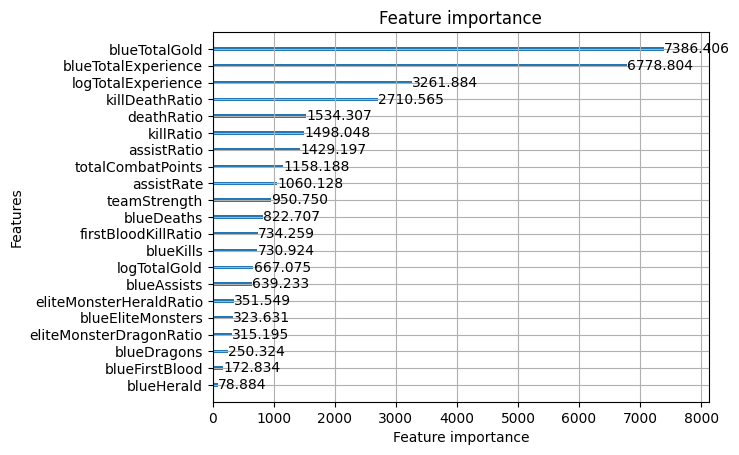

deathRatio: 1038
killRatio: 969
assistRatio: 900
killDeathRatio: 754
assistRate: 747
totalCombatPoints: 747
blueTotalGold: 675
teamStrength: 553
blueDeaths: 488
blueTotalExperience: 434
blueKills: 387
blueAssists: 385
firstBloodKillRatio: 357
logTotalExperience: 328
logTotalGold: 275
eliteMonsterDragonRatio: 145
blueEliteMonsters: 133
eliteMonsterHeraldRatio: 114
blueDragons: 91
blueFirstBlood: 82
blueHerald: 41


In [8]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=50, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=5000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X, y)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)

- testにy_test_pred結合

In [9]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_oputuna_val.csv'

In [10]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [11]:
check = pd.read_csv(output)

In [12]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
